In [1]:
%matplotlib inline


==========================================================
Load CT slices and plot axial, sagittal and coronal images
==========================================================

This example illustrates loading multiple files, sorting them by slice
location, building a 3D image and reslicing it in different planes.

.. usage:

   reslice.py <glob>
   where <glob> refers to a set of DICOM image files.

   Example: python reslice.py "*.dcm". The quotes are needed to protect
   the glob from your system and leave it for the script.

.. note:

   Uses numpy and matplotlib.

   Tested using series 2 from here
   http://www.pcir.org/researchers/54879843_20060101.html


785
glob: -f
file count: 785
skipped, no SliceLocation: 0


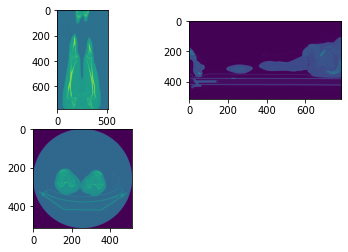

In [2]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

# load the DICOM files
import os
PathDicom = "/media/mkrnaqeebi/Downloads/Freelancer/CT/FirstFive/Pat1/CT_scan/DICOM/PA000001/ST000001/SE000005"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".zip" not in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
print(len(lstFilesDCM))
files = []
print('glob: {}'.format(sys.argv[1]))
for fname in lstFilesDCM:
#     print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 3)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 1)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()

In [9]:
import ipyvolume as ipv
N = 1000
x, y, z = np.random.normal(0, 1, (3, N))
fig = ipv.figure()
scatter = ipv.scatter(x, y, z, marker='sphere')
# ipv.show()
ipv.save('example.html')

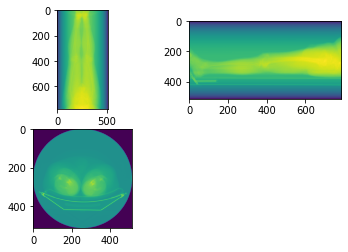

In [13]:

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 3)
plt.imshow(img3d.sum(2))
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d.sum(1))
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 1)
plt.imshow(img3d.sum(0).T)
a3.set_aspect(cor_aspect)

plt.show()

In [14]:
# make 3d np array from all slices
unset = True
tem = slices
for i in range(len(tem)):
    arr = tem[i].pixel_array.astype(np.float32)
    if unset:
        imShape = (arr.shape[0], arr.shape[1], len(tem))
        scaledIm = np.zeros(imShape)
        pix_spacing = tem[i].PixelSpacing
        dist = 0
        for j in range(2):
            cs = [float(q) for q in tem[j].ImageOrientationPatient]
            ipp = [float(q) for q in tem[j].ImagePositionPatient]
            parity = pow(-1, j)
            dist += parity*(cs[1]*cs[5] - cs[2]*cs[4])*ipp[0]
            dist += parity*(cs[2]*cs[3] - cs[0]*cs[5])*ipp[1]
            dist += parity*(cs[0]*cs[4] - cs[1]*cs[3])*ipp[2]
        z_spacing = abs(dist)
        slope = tem[i].RescaleSlope
        intercept = tem[i].RescaleIntercept
        unset = False
    scaledIm[:, :, i] = arr

# convert to hounsfield units
scaledIm = slope*scaledIm + intercept
pix_spacing.append(z_spacing)

wl = 300    # window parameters for Angio
ww = 600

windowed = np.zeros(imShape, dtype=np.uint8)
# allImages[scaledIm <= (wl-0.5-(ww-1)/2.0)] = 0
k = np.logical_and(scaledIm > (wl-0.5-(ww-1)/2.0), scaledIm <= (wl-0.5+(ww-1)/2.0))
windowed[k] = ((scaledIm[k] - (wl-0.5))/(ww-1)+0.5)*255
windowed[scaledIm > (wl-0.5+(ww-1)/2.0)] = 255
# windowed image (in 2D) is correct i checked visually in other DICOM viewers
print("arrays made %s" % (time.time() - st))


# Volume(scaledIm, spacing=pix_spacing).show(bg="black")
Volume(windowed, spacing=pix_spacing).show(bg="black")

# X, Y, Z = np.mgrid[:30, :30, :30]
# scalar_field = ((X-15)**2 + (Y-15)**2 + (Z-15)**2)/225
# Volume(scalar_field, spacing=pix_spacing).show(bg="black")      # looks good on this example


MemoryError: 